# Reddit Word Usage Project

## Introduction and Background

Our group shares a common interest in video games, passing time on the web, and studying Computer Science. Whether we are busy programming or playing with friends, Reddit remains a constant in our workflow and procrastination. It is the one stop source for all things informational or entertaining: it allows us to look up the latest updates on our favorite video games, check the latest UCSD events, catch up on national and global news, or just look at gifs of cats.

We coincidentally came across our dataset on Reddit but it alone didn't give much to work with. Thinking of relevant questions for this dataset led us to look for other datasets. When we came across the next dataset of common words, we wanted to know how they differ, and why. 

Knowing the differences can show clear indications of Reddit's dominant demographic. Understanding the source of our information helps us remember biases inherent in the posts we read on Reddit. For example, Time analyzed the top 500 most words used on Twitter, and tinyurl.com is the 11th most common word. However, Twitter's character limit has an enormous influence on the outcome of Time's analysis. Other biases include misinformation on Reddit, or hidden advertisements in posts, which brings up another interesting question: Which buzzwords appeal the most to Redditors.

Reddit also conducts surveys of their own userbase so we have our estimates and factual analysis to compare with. That way we better understand if our methods and techniques return correct conclusions, so that they can be applied to different areas.

### Research Question
How does Reddit word usage differ from US English word usage? Given data about the Reddit demographic, what can we say about the vocabulary of the average Reddit user?

### Hypothesis
Given that [54% of Redditors](https://reddit.zendesk.com/hc/en-us/articles/205183225-Audience-and-Demographics) are from the United States, and that English is the primary language on Reddit, we hypothesize that Reddit word usage is rather similar to US English word usage.
Given an [informal survey](http://imgur.com/gallery/cPzlB) of the Reddit demographic, we hypothesize that differences in word usage can be attributed to the predominantly younger male demographic.

In [46]:
# Imports -  Probably excessive on the imports but it is anything we could possibly use
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
from scipy.stats import ttest_ind

## Data Description

For this project, we have two different sets of data. 

The first data set is a construct of the top most frequently used words from Reddit,
as mined from over 3 billion comments. The user wanted to try to get a feel for the most frequently words used on Reddit, thus a sample of over 3 billion comments was used. A large enough sample would eventually start showing patterns of word frequency across multiple subreddits. We included this data set into our repository as "reddit_words.csv" and imported it as df_reddit.

The "reddit_words.csv" contains 1 million entries, and 3 columns. The first column is the word itself, the second column is the frequency, and the third column is the percentage they occur at. The data is sorted by the second column, with the first index having the highest frequency, and the last index having the lowest frequency. There is no heading row for this sheet.

The other data set is the list of the 10,000 most common English words in order of frequency, as determined by n-gram analysis of the Google's Trillion Word Corpus. We found it at this [GitHub Repo](https://github.com/first20hours/google-10000-english). We included this data set into our repository as "google10k.csv" and imported it as df_normal.

The "google10k.csv" contains 10,000 entries, and 1 column. The first and only column is the word itself, and is ordered by frequency, with the first index having the highest frequency.

In [2]:
# Load the two datasets we need into their own dataframes
df_reddit = pd.read_csv("reddit_words.csv", header=None)
df_normal = pd.read_csv("google10k.csv", header=None)

In [3]:
# Format the dataframe columns
df_reddit.columns = ['word', 'freq', 'perc']
df_normal.columns = ['word']

## Data Cleaning/Pre-processing

Our process of cleaning data is to remove irrelevant data so we can make comparisons between the two datasets with words that matter. There is also the obvious difference in size between the two data sets, with the Reddit data set containing low frequency words that do not exist in the English language. For example, typos, symbols, or the names of subreddits.

Most of this section is pre-processing because the data sets we are utilizing has mostly been cleaned.

In [4]:
# Remove the bottom half of the Reddit comments as they are trivial
df_reddit = df_reddit.head(50000)

To clean this data, we remove many of the Reddit words of very low frequency because we are using it to compare to a list that is a hundred times smaller. To be safe, we only removed the bottom half as many of those could be usernames or typo'd words. A little later on, we also remove the frequency and percent columns as they are not needed for our analysis.

In [5]:
# Remove numbers from df_reddit
df_reddit = df_reddit[df_reddit['word'].str.isdigit() == False]

# Remove contractions from df_reddit
df_reddit = df_reddit[df_reddit['word'].str.contains('\'') == False]

We noticed df_reddit contains numbers like "3" and contractions like "it's", while df_normal didn't. Because we're comparing word usage, we felt like contractions and numbers in digit format was irrelevant to our analyses. These values could potentially throw off our visualizations.

In [6]:
# Save a copy of cleaned df_reddit for another data set, because we want the frequency column
df_outside = df_reddit.head(10000)

# Drop the two columns of the Reddit words as we have no use for frequency or percentage in this analysis.
df_reddit = df_reddit.drop("freq", 1)
df_reddit = df_reddit.drop("perc", 1)

In [7]:
# Make variables to perform loop operations
redIndex = 0
diffIndex = 0
diffList = []
outList = []
noDiffList = []

# Loop through the top 1000 words and find their relative indices in the Reddit list
for indexi, row in df_normal.itertuples():
    # Get the index of the word in the reddit dataframe and relate it to indexi
    currCol = df_reddit[df_reddit['word'] == row]
    if currCol.empty:
        outList.append(row)
    else:
        redIndex = df_reddit[df_reddit['word'] == row].index[0]
        diffIndex = (redIndex - indexi)
        diffList.append(diffIndex)
        
        if diffIndex == 0:
            noDiffList.append(row)

To analyze the data we will find the difference in indices between words in the two sets and remove any outliers, as well as restrict the ranges on our visualizations. The difference in indices represents the different in popularity for a given word that is in both sets. We print out a sample below:

In [8]:
# Throw the list we got of differences into a dataframe
df_diff = pd.DataFrame(diffList)
df_diff.columns = ['difference']
print(df_diff.head(15))

    difference
0            0
1            4
2            2
3           -2
4           -2
5            5
6            5
7            1
8            5
9            0
10          52
11           1
12           5
13         -10
14          -8


In [9]:
# Remove extreme outliers
df_lessOut = df_diff[df_diff.difference < 10000]

The previous pre-processing gives us data of the words in both of the sets. Now, we want to obtain some data in df_reddit that is not inside df_normal. Due to the sheer size of df_reddit, we only want to examine the top 10,000 words as well.

In [10]:
# We previously had a cleaned version of df_reddit, called df_outside that only includes top 10,000
df_outside = df_outside.drop("perc", 1)

# Remove words that belong in both sets from df_outside
for w in df_normal['word']:
    df_outside = df_outside[df_outside.word != w]

In the above code, we took out everything from df_outside that was in df_normal. Remember that df_outside is a shorter version of df_reddit, with the frequency column retained.

## Data Visualization

From our cleaning and pre-processing section, we have several data sets that are prepared for visualization.
The first section concerns words mutually included in the sets, and how we visualize popularity and similarity.
The second section conerns words uniquely in Reddit.

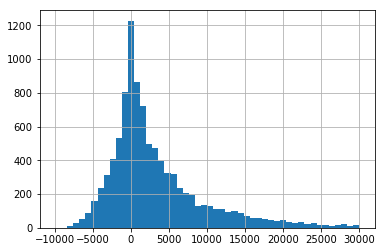

In [11]:
# Represent data by a histogram
df_diff['difference'].hist(bins=50, range=(-10000, 30000))

plot1 = plt.gcf()

In [12]:
# Have descriptive stats to have another viewpoint on the data
df_lessOut.describe()

,difference
count,8345.000000
mean,1214.691552
std,3433.799104
min,-8603.000000
25%,-922.000000
50%,668.000000
75%,3325.000000
max,9999.000000


In [13]:
print(len(outList))

248


In [14]:
print(len(noDiffList))

5


In [15]:
# Check differences in gender specific language
heR  = df_reddit[df_reddit['word'] == "he"].index[0]
heN  = df_normal[df_normal['word'] == "he"].index[0]
sheR = df_reddit[df_reddit['word'] == "she"].index[0]
sheN = df_normal[df_normal['word'] == "she"].index[0]

# Get relative differences
genR2 = heR - sheR
genN2 = heN - sheN

print('Gender Difference Example: \'he\' is more popular relative to \'she\' on Reddit versus general English by',genR2 - genN2,'ranks')

Gender Difference Example: 'he' is more popular relative to 'she' on Reddit versus general English by 48 ranks


In [16]:
# Variables to continue with loop
size = 10000
redditS = []
normalS = []

# Loop to get the length of words in each list
for i in range(size):
    if type(df_reddit.iloc[i][0]) != type(1.0):
        redditS.append(len(df_reddit.iloc[i][0]))
        normalS.append(len(df_normal.iloc[i][0]))

In [17]:
# Put the lengths of words for both lists into a single dataframe
wordLenRed = pd.DataFrame({'reddit': redditS, 'regular': normalS})

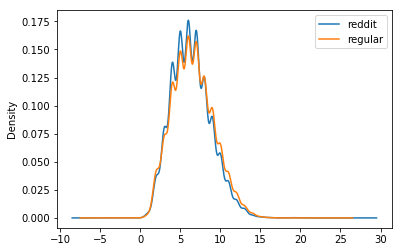

In [18]:
# Density plot them to see their differences
wordLenRed.plot.kde();

For our second section, df_outside, we want to visualize unique words in an interesting way.

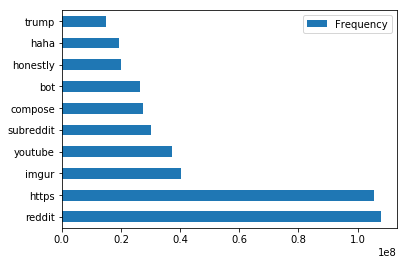

In [19]:
# Look at the most frequent unique words in df_reddit
df_peek = df_outside.head(10)
df_peek.columns = ['word','Frequency']

# Horizontal bar plot
plot3 = df_peek.plot(kind='barh')
plot3.set_yticklabels(df_peek.word);

What are the top 15 words, without https and reddit? It's obvious that these two words would be the most popular unique phrases, because Reddit is the name of the website and https is the beginning of a copy-pasted link.

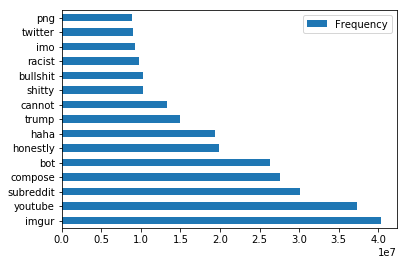

In [20]:
# Take first 17 words, and remove first 2
df_peek2 = df_outside.head(17)
df_peek2.columns = ['word','Frequency']

df_peek2 = df_peek2[df_peek2['word'] != "reddit"]
df_peek2 = df_peek2[df_peek2['word'] != "https"]
plot4 = df_peek2.plot(kind='barh')
plot4.set_yticklabels(df_peek2.word);

## Data Analysis and Results

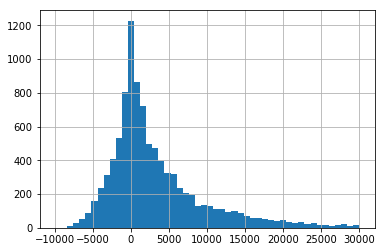

In [21]:
plot1 # First histogram we printed

In [22]:
df_lessOut.describe() # The data describing plot1

,difference
count,8345.000000
mean,1214.691552
std,3433.799104
min,-8603.000000
25%,-922.000000
50%,668.000000
75%,3325.000000
max,9999.000000


The histogram shows the difference in index of each word for their traditional ranks and their ranks on Reddit. The graph is normal with a strong skew to the right which can be attributed to comparing a list of 10,000 to a list of 50,000. The top of the curve is at the bin covering zero so we know for the most part, word's ranks don't stray too far from each other. The mean is at 1200 ranks higher on Reddit on average for words but the median is 668 above, which also is attributed to having the skew towards the high thousands. Keep in mind these numbers are coming from differences of less than 10,000 to remove most of the outliers.

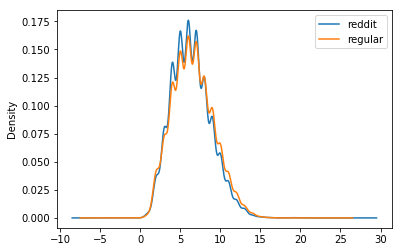

In [23]:
wordLenRed.plot.kde(); # The second visualization we made

Furthermore, some other interesting observations were made in the process of comparing the two data sets. For example, only 5 words have a difference of 0, and 2 of those were in the top 10 words. That means that there is a continuous bias of word usage on Reddit. Also, there were 248 words from the general English list that didn't even show up on the top 50,000 words on Reddit. I would assume that the reason for this discrepancy comes from the audience of Reddit. Considering Reddit comments are rated by other users, users are encouraged to use more widely known language to appeal to a larger base, whereas the Google Corpus list takes info from books which may have a bias towards more intellectual audiences. As shown by the density plots showing the length of words from the two sources side by side, reddit's word's tend to be shorter on average, agreeing with the aforementioned affect the audience has. 

As for gender specific differences, it is hard to measure how 'young' and 'male' affects the data because it would interject many of our own biases, however as an overarching view on it, we found that 'he' is more popular than 'she' on Reddit which provides evidence to back up the claim of that part of Reddit's demographic.

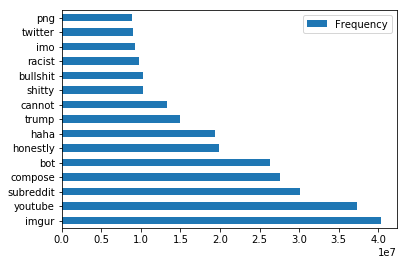

In [24]:
plot4 = df_peek2.plot(kind='barh')
plot4.set_yticklabels(df_peek2.word); # The fourth visualization we made

For this visualization, we explored the top 15 words in df_reddit that are not in df_normal. We expected these words to be highly specific to the vocabulary of Redditors, which ended up being correct. In this visualization, we took out the top 2, which was "reddit" and "https". We did this because "reddit" lacked significance; of course "reddit" would be the most used word on a website called "Reddit". In addition, "https" is the beginning of a link, which also lacks significance in terms of word usage.

As a result, we see some interesting results. There are technologically relevant words, such as "youtube", "imgur", and "twitter" which are websites; "subreddit", "bot" which are reddit-specific terms; "png" which is a graphical file extension. In addition, there is the acronym "imo" (In my opinion), "haha", and "honestly", which may indicate an expression of opinion. There are also some words with heavier connotations, such as "racist", "bullshit", and "shitty". Finally, there's also an incredibly controversial term (which results in more mentions), "trump".

## Conclusions and Discussion

Given that [54% of Redditors](https://reddit.zendesk.com/hc/en-us/articles/205183225-Audience-and-Demographics) are from the United States, and that English is the primary language on Reddit, we hypothesize that Reddit word usage is rather similar to US English word usage.
Given an [informal survey](http://imgur.com/gallery/cPzlB) of the Reddit demographic, we hypothesize that differences in word usage can be attributed to the predominantly younger male demographic.

Our hypothesis stated that Reddit word usage is rather similar to US English word usage. Considering the size differences of the list, seeing the frequency of words that have such a small difference in ranks, it agrees with our hypothesis that Reddit's dominant US demographic has words aligned with general US word usage. In comparing our two data sets, we saw that words near the top (more frequently appearing words) have fewer discrepancies between the two data sets in terms of word frequency. This further pushes us to believe that our original hypothesis was on the right track. This may be expected, considering that the primary language of Reddit is English, and the primary language of the US is English.

We believed that differences in word usage can be attributed to the predominantly younger male demographic. However, we found that it is a lot harder to measure how the demographic of Reddit affects the data than we originally believed. We ended up being unable to pursue this line of thought in our analyses, as we realized we needed more data. To connect to demographic statistics, we needed a data set that would connect US demographics and common word usage; however, we were unable to find any reliable sources. Therefore, we were __unable__ to prove this part of our hypothesis.

This analysis is based purely off of word frequency. Further examination and research may lead to more interesting findings.  For example, certain words may be used in different contexts, but that data does not show up in analysis of word frequency. Based off of pure data, we don't know whether or not ambiguous words like 'wish' are used as verbs or nouns. Another interesting find is that Redditors tend to be very lazy in correct grammar. We found that they tend not to use apostrophes for whatever reason so that might bump words like 'its' much higher than its actual intended frequency. These findings are interesting and aren't found directly through word frequencies. Doing analysis based solely off of word frequency gives us very concrete results, but doesn't necessarily tell the entire story of word usage within Reddit and the US.